In [1]:
import gdown
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

import tensorflow as tf

# Data Information

In [2]:
train_file_id = '1Eg_MFWmax7r6O9AY7U9Z08J1c5LX6N43'
train_output_file = 'train.csv'  

train_download_url = f'https://drive.google.com/uc?id={train_file_id}'

gdown.download(train_download_url, train_output_file, quiet=False)

df = pd.read_csv(train_output_file)

Downloading...
From: https://drive.google.com/uc?id=1Eg_MFWmax7r6O9AY7U9Z08J1c5LX6N43
To: d:\Document\Bangkit\Regression\train.csv
100%|██████████| 567k/567k [00:02<00:00, 224kB/s]


In [3]:
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [5]:
variables = [col for col in df.columns if df[col].nunique() <= 10]
for var in variables:
  print(f"====={var}=====")
  unique_values = df[var].unique()
  n_unique_values = df[var].nunique()
  value_counts = df[var].value_counts()

  print(f"Unique values in {var}: {unique_values}")
  print(f"Number of unique values in {var}: {n_unique_values}")
  print(f"Value counts in {var}:\n{value_counts}\n")

=====BHK=====
Unique values in BHK: [2 1 3 6 4 5]
Number of unique values in BHK: 6
Value counts in BHK:
BHK
2    2265
1    1167
3    1098
4     189
5      19
6       8
Name: count, dtype: int64

=====Area Type=====
Unique values in Area Type: ['Super Area' 'Carpet Area' 'Built Area']
Number of unique values in Area Type: 3
Value counts in Area Type:
Area Type
Super Area     2446
Carpet Area    2298
Built Area        2
Name: count, dtype: int64

=====City=====
Unique values in City: ['Kolkata' 'Mumbai' 'Bangalore' 'Delhi' 'Chennai' 'Hyderabad']
Number of unique values in City: 6
Value counts in City:
City
Mumbai       972
Chennai      891
Bangalore    886
Hyderabad    868
Delhi        605
Kolkata      524
Name: count, dtype: int64

=====Furnishing Status=====
Unique values in Furnishing Status: ['Unfurnished' 'Semi-Furnished' 'Furnished']
Number of unique values in Furnishing Status: 3
Value counts in Furnishing Status:
Furnishing Status
Semi-Furnished    2251
Unfurnished       1815
Fu

# Feature Engineering

## Transformation

In [6]:
df['LogRent'] = np.log10(df['Rent'])
df['LogSize'] = np.log10(df['Size'])

## Adding new features

In [7]:
df['Level'] = df['Floor'].apply(lambda x: x.split()[0])
df['NumberFloors'] = df['Floor'].apply(lambda x: x.split()[-1])

df['NumberFloors'] = df['NumberFloors'].replace('Ground', 0)
df['Level'] = df['Level'].replace({'Ground': 0, 'Lower': 0})

df.loc[df['Level'] == 'Upper', 'Level'] = df['NumberFloors']

df['Level'] = pd.to_numeric(df['Level']) + 1
df['NumberFloors'] = pd.to_numeric(df['NumberFloors']) + 1

df['Height'] = df['Level'] / df['NumberFloors']

## Encoding

In [8]:
df = pd.get_dummies(df, columns=['Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred'], drop_first=True)

## Scaler

In [9]:
rb = RobustScaler()
columns = [col for col in df.columns if col not in variables and col not in ['Floor', 'Posted On', 'Area Locality']]

for col in columns:
    df[col] = rb.fit_transform(df[[col]])  

## Outliers

In [10]:
q_high = df['Rent'].quantile(0.99)
q_low = df['Rent'].quantile(0.01)
df = df[(df['Rent'] < q_high) & (df['Rent'] > q_low)]

# Modelling

## Train Test Split

In [11]:
features = [col for col in df.columns if col not in ['Rent','Floor','LogRent','LogSize','Point of Contact','Posted On']]
target = 'Rent'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape = (X_train.shape[1], )))
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1, activation = 'linear'))
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       576,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 628,097 (2.40 MB)

 Trainable params: 627,073 (2.39 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [13]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2.3440 - mean_absolute_percentage_error: 17918782.0000 - val_loss: 2.3849 - val_mean_absolute_percentage_error: 7465509.0000
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.9380 - mean_absolute_percentage_error: 10145331.0000 - val_loss: 2.1817 - val_mean_absolute_percentage_error: 3878977.0000
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.8401 - mean_absolute_percentage_error: 6879077.5000 - val_loss: 1.4423 - val_mean_absolute_percentage_error: 3775973.2500
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6111 - mean_absolute_percentage_error: 7324003.0000 - val_loss: 1.1399 - val_mean_absolute_percentage_error: 5038689.0000
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5497 - mean_absolute_percentage_error: 6655382.5000 - val_loss: 0.6372 - val_mean_absolute_percentage_error: 5682971.5000
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4421

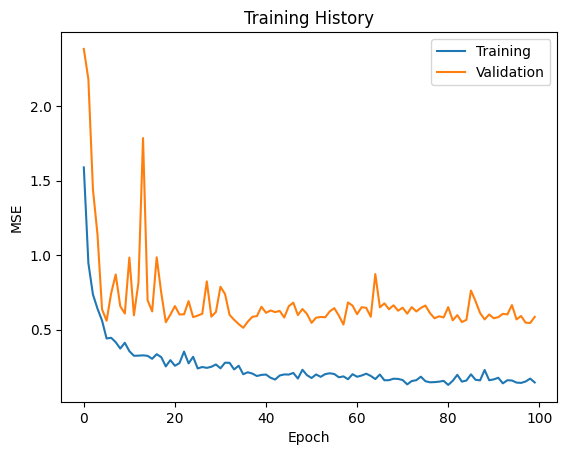

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training','Validation'])
plt.show()